# State of Health Prediction using LSTM and RUL Estimation using Deterministic Model

Create SoH prediction using LSTM and RUL estimation using Linear Regression for smartphone battery degradation. This notebook include EDA, Feature Engineering, Data Processing, Model Building, and Evaluation.

## Data Preprocessing

### Data Extraction

Extract smartphone data from Supabase collected from smartphone application

In [1]:
# Import necessary modules
import os
import sys
from pathlib import Path

# Define current and root directory paths
CWD = Path().resolve()
ROOT = CWD.parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.utils.utils import connect_to_db
from dotenv import load_dotenv
load_dotenv(ROOT / ".env")

# Define database connection parameters
PORT = os.getenv("PORT")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
DATABASE = os.getenv("DATABASE")

# Check connection parameters
if not all([PORT, USERNAME, PASSWORD, HOST, DATABASE]):
    print("Error: One or more database connection parameters are missing.")
    sys.exit(1)

# Establish connection to the database
conn = connect_to_db(HOST, PORT, DATABASE, USERNAME, PASSWORD)

Connection to database established successfully.


### Data Convertion

Convert extracted data from Supabase into dataframe format, ensure all the columns matches the data type.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Extract data from the database
with conn.cursor() as cursor:
  cursor.execute("SELECT * FROM public.raw_metrics ORDER BY device_id, created_at ASC")
  data = cursor.fetchall()
  # Convert to DataFrame
  df = pd.DataFrame(data, columns=[desc[0] for desc in cursor.description])

# Ensure sorted data
df["created_at"] = pd.to_datetime(df["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)

In [3]:
# Count device id but maximum 500
plt.figure(figsize=(15, 7))
device_counts = df["device_id"].value_counts().clip(upper=500)
device_counts

device_id
2311DRK48G-b135dcd1d7e9320f          500
SM-A336E-c471046323c8859c            500
SM-S931B-57bc0e2d9eac7750            500
SM-S921B-d2c3f5675ad3a14d            500
SM-S911B-aee10fcb8586030e            500
2312DRA50G-223024e791e6150d          500
Infinix X669C-a1b2d29d54d19af3       500
22021211RG-0940e2943d7b49eb          500
SM-A155F-7d69b63bc200801a            500
SM-S926B-1ccc6862dc88e6b9            500
SM-S916B-205d95c2abec51c0            500
SM-A546E-701861f29b4d5913            500
SM-A356E-4e32dd36015962aa            500
2406APNFAG-4b17a6ddf26cd705          500
SM-A336E-c89e0bb491fe3651            500
SM-A546E-1cf82eec40a3542b            500
SM-A725F-6698366a2e3a4ff1            500
24117RN76O-af9a140a5e0ea0de          414
CPH2579-13dc1e10ddca7976             358
vivo 1919-6f29a965f06687bd           338
SM-A556E-5f0400c50aae82ca            275
SM-A556E-7ecd175336df7fc4            236
SM-A256E-7e0aca17c219854b            201
V2050-b202c09b34bc8540               143
SM-T50

<Figure size 1500x700 with 0 Axes>

In [4]:
# Convert to Jakarta timezone
import pytz
df['created_at'] = df['created_at'].dt.tz_convert('Asia/Jakarta')
df['ts_utc'] = df['ts_utc'].dt.tz_convert('Asia/Jakarta')

# Check null values
df.isnull().sum()

# Drop unused columns
df.drop(["charge_source", "energy_nwh", "cycles_count", "current_avg_ua"], axis=1).head()

,id,user_id,device_id,ts_utc,net_type,channel_quality,rx_total_bytes,tx_total_bytes,batt_voltage_mv,batt_current_ua,batt_temp_c,is_charging,battery_health,battery_level,charge_counter_uah,battery_capacity_pct,fg_pkg,created_at
0,5f9a61dc-10af-462a-af07-00cc8e452677,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:10.349366+07:00,WiFi,-56,2014928638,112746489,3703,623000,35.5,False,GOOD,16.0,518000,16,Device Analytics,2025-11-10 20:26:11.940321+07:00
1,6057bf9c-b150-4ec8-8786-7d731bb7ec94,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:11.805850+07:00,WiFi,-56,2014928978,112747759,3703,623000,35.5,False,GOOD,16.0,518000,16,Device Analytics,2025-11-10 20:26:12.630878+07:00
2,d55733e0-af40-45b7-8380-d39ba4f92bec,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:29:59.093424+07:00,WiFi,-54,2045926067,114374859,3586,653000,36.1,False,GOOD,15.0,488000,15,Instagram,2025-11-10 20:30:00.489796+07:00
3,f178b802-d1d3-4280-b371-a4460cccdeed,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:53:21.834407+07:00,WiFi,-59,2055732576,115764715,3467,1524000,32.5,False,GOOD,14.0,437000,14,Device Analytics,2025-11-10 20:53:22.714987+07:00
4,75c65cc2-7db9-4d2e-aab7-9a0caced7ce5,None,22021211RG-0940e2943d7b49eb,2025-11-10 21:09:33.882115+07:00,WiFi,-60,2062366807,117028496,4305,-4525000,36.0,True,GOOD,20.0,612000,20,Discord,2025-11-10 21:09:34.698560+07:00


In [5]:
# Count device IDs rows
df['device_id'].value_counts()

device_id
2311DRK48G-b135dcd1d7e9320f          2198
SM-A336E-c471046323c8859c            1923
SM-S931B-57bc0e2d9eac7750            1658
SM-S921B-d2c3f5675ad3a14d            1568
SM-S911B-aee10fcb8586030e            1536
2312DRA50G-223024e791e6150d          1256
Infinix X669C-a1b2d29d54d19af3       1242
22021211RG-0940e2943d7b49eb          1172
SM-A155F-7d69b63bc200801a            1039
SM-S926B-1ccc6862dc88e6b9             853
SM-S916B-205d95c2abec51c0             824
SM-A546E-701861f29b4d5913             741
SM-A356E-4e32dd36015962aa             720
2406APNFAG-4b17a6ddf26cd705           715
SM-A336E-c89e0bb491fe3651             712
SM-A546E-1cf82eec40a3542b             711
SM-A725F-6698366a2e3a4ff1             681
24117RN76O-af9a140a5e0ea0de           414
CPH2579-13dc1e10ddca7976              358
vivo 1919-6f29a965f06687bd            338
SM-A556E-5f0400c50aae82ca             275
SM-A556E-7ecd175336df7fc4             236
SM-A256E-7e0aca17c219854b             201
V2050-b202c09b34bc8540  

### Histogram Plot

Plot the data columns as histogram plot to extract the insights

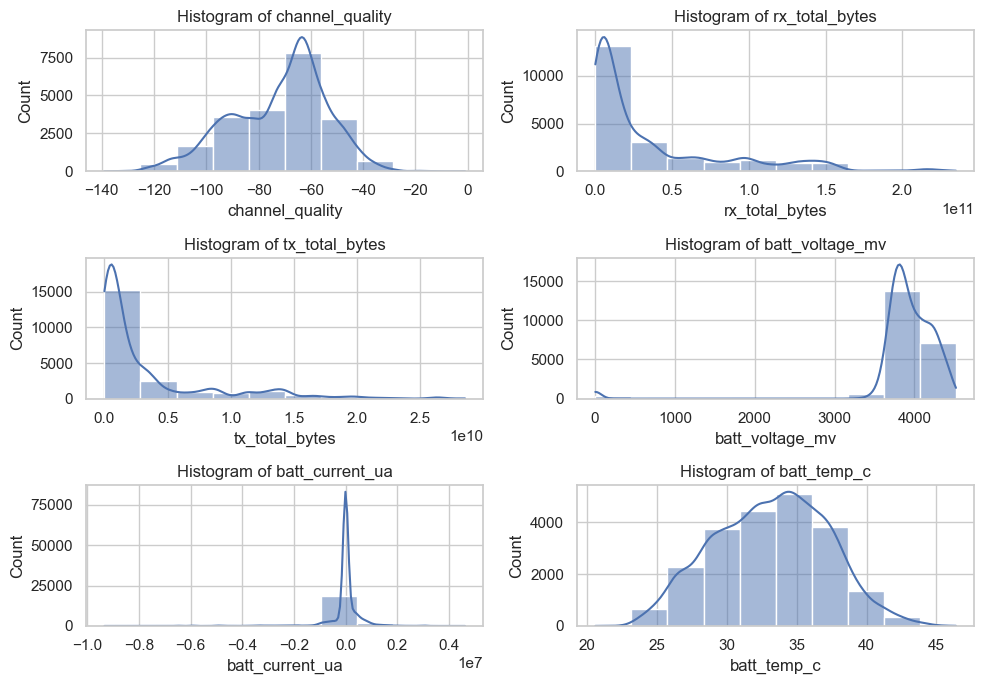

In [6]:
import seaborn as sns

plt.rcParams['agg.path.chunksize'] = 20000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 7))

# List of numerical columns
numerical_cols = ['channel_quality', 'rx_total_bytes', 'tx_total_bytes', 'batt_voltage_mv',
'batt_current_ua', 'batt_temp_c', "charge_counter", "battery_capacity_pct"]

# Plot histograms for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(df[col], bins=10, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

### Throughput and Energy Calculation

Calculate throughput and energy over time from smartphone data collected from Supabase

In [7]:
# Ensure 'created_at' is in datetime format
df["created_at"] = pd.to_datetime(df["created_at"])

# Calculate time difference in seconds
df["delta_t"] = df["created_at"].diff().dt.total_seconds().fillna(0)

# Convert voltage from mV to V and current from uA to A
df["batt_voltage_v"] = df["batt_voltage_mv"] / 1000
df["batt_current_a"] = df["current_avg_ua"] / 1_000_000

# Energi per step (Joule)
df["energy_over_time"] = df["batt_voltage_v"] * df["batt_current_a"] * df["delta_t"]
df["energy_over_time"] = df["energy_over_time"] / 3600

# Calculate throughput
df = df.sort_values("ts_utc")
df["delta_t"] = df["ts_utc"].diff().dt.total_seconds()
df["delta_tx"] = df["tx_total_bytes"].diff()
df["delta_rx"] = df["rx_total_bytes"].diff()

df["throughput_total_bps"] = (df["delta_tx"] + df["delta_rx"]) * 8 / df["delta_t"]

# Drop NaN values
df.loc[df["delta_t"] <= 0, "throughput_total_bps"] = np.nan
df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)

df["throughput_total_mbps"] = df["throughput_total_bps"] / 1e6

C:\Users\Fadel\AppData\Local\Temp\ipykernel_31392\2251008585.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)


### Calculate Energy per Bit

Calculate energy per bit using Throughput metrics. The equation derived from *Energy Model for Data Transfer* paper, alpha and beta values used from paper. 

In [8]:
# Replace zero throughput with NaN to avoid division by zero
df["throughput_total_bps"] = df["throughput_total_bps"].replace(0, np.nan)

# Cofficient from paper
alpha_tx = 446.2936  # nJ/bit
beta_tx = 3.381132   # nJ/bit
alpha_rx = 357.5443  # nJ/bit
beta_rx = 1.969068   # nJ/bit

# Energy per bit calculation
df["energy_per_bit_tx"] = (alpha_tx / df["throughput_total_bps"]) + beta_tx
df["energy_per_bit_rx"] = (alpha_rx / df["throughput_total_bps"]) + beta_rx
df["energy_per_bit_tx_J"] = df["energy_per_bit_tx"] * 1e-9
df["energy_per_bit_rx_J"] = df["energy_per_bit_rx"] * 1e-9

# Energy per bit total calculation
df["energy_per_bit_avg_J"] = (df["energy_per_bit_tx_J"] + df["energy_per_bit_rx_J"]) / 2

# Preview result
df[[
  "ts_utc",
  "throughput_total_bps",
  "energy_per_bit_tx_J",
  "energy_per_bit_rx_J",
  "energy_per_bit_avg_J",
]].head()

,ts_utc,throughput_total_bps,energy_per_bit_tx_J,energy_per_bit_rx_J,energy_per_bit_avg_J
19543,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN,NaN
19544,2025-10-31 05:53:30.429297+07:00,1.313596e+06,3.381472e-09,1.969340e-09,2.675406e-09
19545,2025-10-31 06:08:32.072450+07:00,3.407266e+06,3.381263e-09,1.969173e-09,2.675218e-09
19546,2025-10-31 06:23:33.918787+07:00,4.534018e+06,3.381230e-09,1.969147e-09,2.675189e-09
19547,2025-10-31 06:38:35.969953+07:00,5.097230e+06,3.381220e-09,1.969138e-09,2.675179e-09


Calculate battery cost of traffic using average voltage and energy per bit

In [9]:
# Average voltage
V_avg = df["batt_voltage_v"].mean()

# Calculate Battery Cost of Traffic (BoT)
# BoT = (E_b * (8 × 10^9) / V_avg) × (1000 / 3600)
df["BoT_mAh_per_Gbps"] = (df["energy_per_bit_avg_J"] * (8 * 1e9) / V_avg) * (1000 / 3600)

# Preview result
df[["ts_utc", "throughput_total_bps", "energy_per_bit_avg_J", "BoT_mAh_per_Gbps"]].head()

,ts_utc,throughput_total_bps,energy_per_bit_avg_J,BoT_mAh_per_Gbps
19543,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN
19544,2025-10-31 05:53:30.429297+07:00,1.313596e+06,2.675406e-09,1.524073
19545,2025-10-31 06:08:32.072450+07:00,3.407266e+06,2.675218e-09,1.523966
19546,2025-10-31 06:23:33.918787+07:00,4.534018e+06,2.675189e-09,1.523949
19547,2025-10-31 06:38:35.969953+07:00,5.097230e+06,2.675179e-09,1.523944


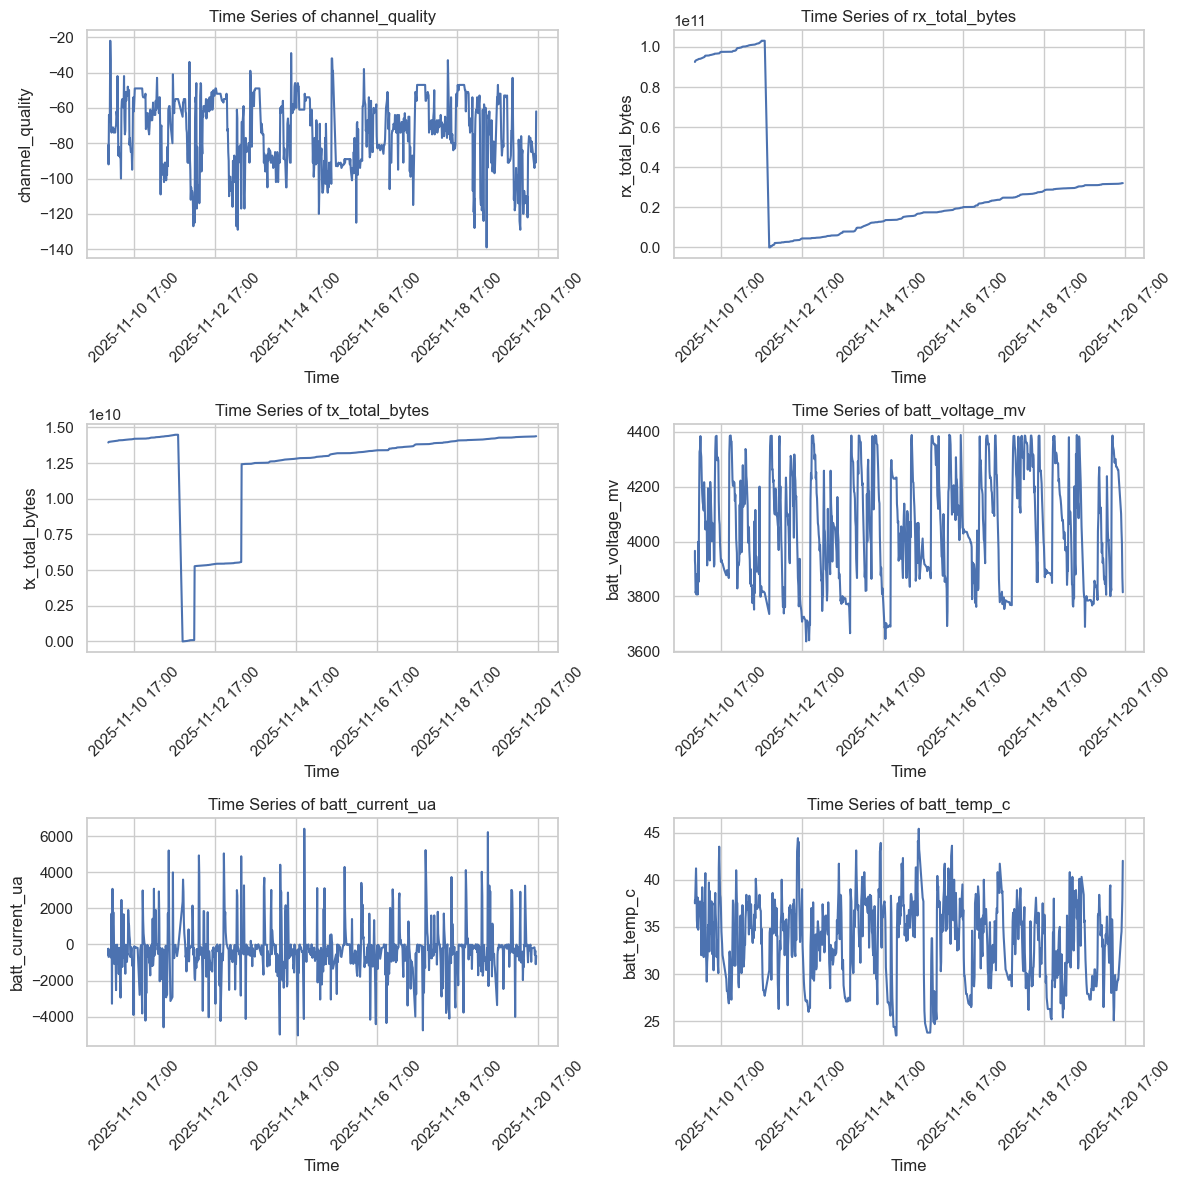

In [10]:
import matplotlib.dates as mdates

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

df_sm = df[df["device_id"] == "SM-S926B-1ccc6862dc88e6b9"]

# Plot line charts for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    ax.plot(df_sm['created_at'], df_sm[col])
    ax.set_title(f'Time Series of {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

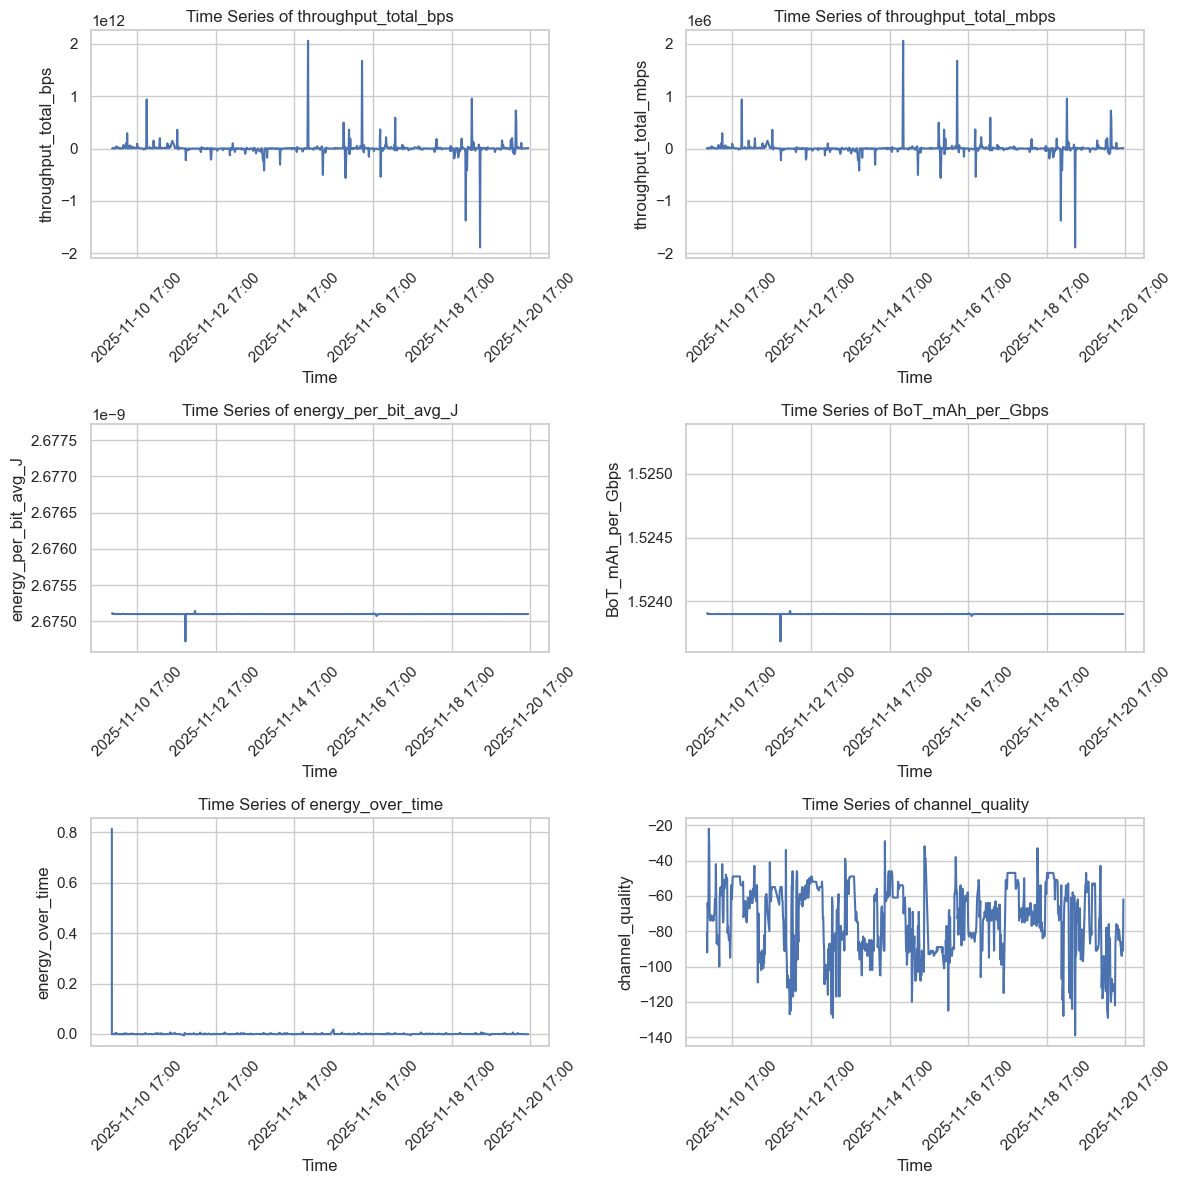

In [11]:
import matplotlib.dates as mdates

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

network_cols = [
  'throughput_total_bps',
  'throughput_total_mbps',
  'energy_per_bit_avg_J',
  'BoT_mAh_per_Gbps',
  "energy_over_time",
  "channel_quality"
]

df_sm = df[df["device_id"] == "SM-S926B-1ccc6862dc88e6b9"]

# Plot line charts for each numerical column
for ax, col in zip(axes.flatten(), network_cols):
    ax.plot(df_sm['created_at'], df_sm[col])
    ax.set_title(f'Time Series of {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Application Usage Analysis

Create bar plot to see most usage application for every devices collected from smartphone battery application.

C:\Users\Fadel\AppData\Local\Temp\ipykernel_31392\113029621.py:11: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  plt.tight_layout()
c:\College\Bachelor\smartphone-battery-be\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


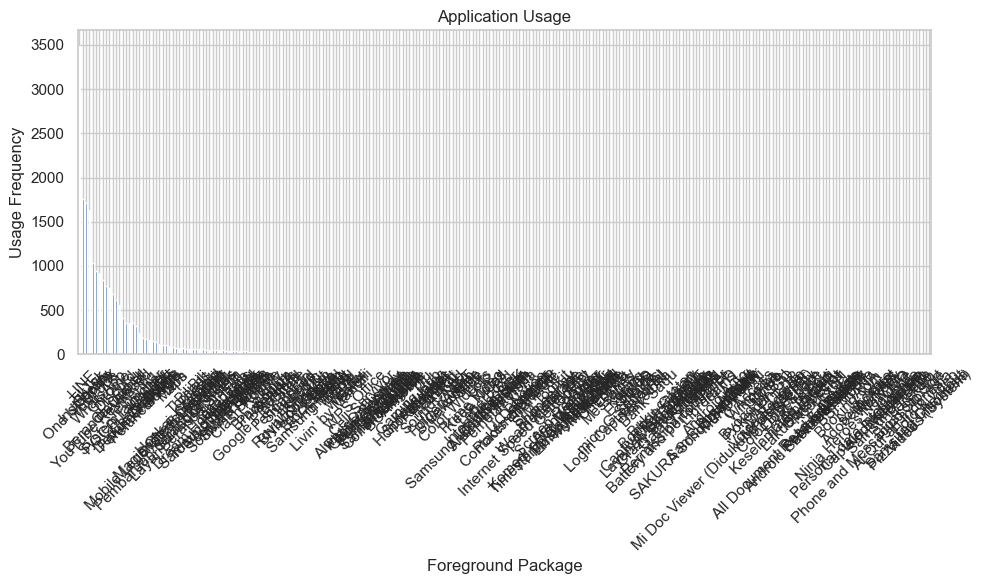

In [12]:
# Count the occurrences of each package
package_counts = df['fg_pkg'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
package_counts.plot(kind='bar')
plt.title('Application Usage')
plt.xlabel('Foreground Package')
plt.ylabel('Usage Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Detect infinix devices

In [13]:
# Detect all Infinix devices in df_all
infinix_devices = sorted([
  d for d in df["device_id"].unique()
  if "Infinix" in str(d)
])
print("Infinix devices detected:", infinix_devices)


Infinix devices detected: ['Infinix X669C-a1b2d29d54d19af3', 'Infinix X6886-e495e4491a5c2a82']


## Model Building

Create LSTM model to predict smartphone battery State of Health.

In [14]:
import os
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [15]:
df = df[~df["device_id"].isin(infinix_devices)].copy()
print("Remaining devices:", df["device_id"].nunique())

Remaining devices: 27


### Calculate State of Health and Battery Cycles

Create function to calculate state of health and battery cycles for LSTM prediction

In [16]:
from src.utils.utils import calculate_soh_and_cycles

# Merge device
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna(subset=["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)


# Merge SoH calculation for all devices
df_all = (
  df
  .groupby("device_id", group_keys=False)
  .apply(lambda g: calculate_soh_and_cycles(g))
)

df_all["SoH_filled"] = df_all["SoH_smooth"].where(
  df_all["SoH_smooth"].notna(), df_all["SoH"]
)

df_all["SoH_filled"] = (
    df_all.groupby("device_id")["SoH_filled"]
          .transform(lambda s: s.ffill().bfill())
)

C:\Users\Fadel\AppData\Local\Temp\ipykernel_31392\4078386457.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calculate_soh_and_cycles(g))


In [18]:
df_dev = df_all[df_all["device_id"]=="SM-S916B-205d95c2abec51c0"]
df_dev["Ct_mAh"].describe()

count    803.000000
mean      11.302788
std        6.580671
min        1.993675
25%        5.214191
50%       11.686172
75%       16.824780
max       23.739729
Name: Ct_mAh, dtype: float64

In [19]:
summary = (
    df_all.groupby("device_id")["SoH_filled"]
          .agg(["count", "min", "max", "std"])
          .sort_values("std", ascending=False)
)

summary


,count,min,max,std
device_id,,,,
SM-A256E-7e0aca17c219854b,201,0.123309,1.032652,0.331937
SM-S921B-d2c3f5675ad3a14d,1568,0.090437,1.073064,0.330747
SM-A546E-1cf82eec40a3542b,711,0.019582,1.032220,0.319638
SM-A546E-701861f29b4d5913,741,0.038458,1.060592,0.307861
SM-A336E-c471046323c8859c,1923,0.105281,1.035484,0.305301
SM-S916B-205d95c2abec51c0,824,0.089284,1.061927,0.303541
SM-A356E-4e32dd36015962aa,720,0.122709,1.041791,0.295389
SM-A556E-7ecd175336df7fc4,236,0.157273,1.064545,0.291452
SM-A155F-7d69b63bc200801a,1039,0.107997,1.004022,0.291083


### Device Summary

Create device summary to check minimum and maximum State of Health values

In [20]:
# Device summary
summary = (df_all.groupby("device_id")["SoH_filled"].agg(["count","min","max"]).sort_values("max", ascending=False))
summary

,count,min,max
device_id,,,
2311DRK48G-b135dcd1d7e9320f,2198,0.006346,1.200000
SM-A725F-6698366a2e3a4ff1,681,0.156255,1.128117
SM-S921B-d2c3f5675ad3a14d,1568,0.090437,1.073064
SM-A556E-7ecd175336df7fc4,236,0.157273,1.064545
SM-S916B-205d95c2abec51c0,824,0.089284,1.061927
SM-A546E-701861f29b4d5913,741,0.038458,1.060592
SM-S926B-1ccc6862dc88e6b9,853,0.214005,1.056782
SM-S931B-57bc0e2d9eac7750,1658,1.047619,1.047619
24117RN76O-af9a140a5e0ea0de,414,0.796485,1.047619


### Quarantine Devices

Exclude devices that had incomplete State of Health data

In [21]:
from src.utils.utils import quarantine_device

bad_devices = quarantine_device(df_all)
print("Bad devices:", bad_devices)

Bad devices: ['22021211RG-0940e2943d7b49eb', '2311DRK48G-b135dcd1d7e9320f', '23124RA7EO-3eb11a599d8b922d', '2312DRA50G-223024e791e6150d', '2406APNFAG-4b17a6ddf26cd705', 'CPH2579-13dc1e10ddca7976', 'Redmi Note 9 Pro-d2c7435268ff2367', 'SM-A155F-7d69b63bc200801a', 'SM-A256E-7e0aca17c219854b', 'SM-A336E-c471046323c8859c', 'SM-A336E-c89e0bb491fe3651', 'SM-A356E-4e32dd36015962aa', 'SM-A546E-1cf82eec40a3542b', 'SM-A546E-701861f29b4d5913', 'SM-A546E-8af17d67f9288898', 'SM-A556E-5f0400c50aae82ca', 'SM-A556E-7ecd175336df7fc4', 'SM-A725F-6698366a2e3a4ff1', 'SM-S911B-aee10fcb8586030e', 'SM-S916B-205d95c2abec51c0', 'SM-S921B-d2c3f5675ad3a14d', 'SM-S926B-1ccc6862dc88e6b9', 'SM-T505-280eb41faa621df0', 'V2050-b202c09b34bc8540', 'vivo 1919-6f29a965f06687bd']


Sanity check to ensure the State of Health between 0 - 1.2

In [22]:
# Sanity checks
print("Devices:", df_all["device_id"].nunique(), "Rows:", len(df_all))
assert (df_all["SoH_filled"].dropna().between(0, 1.2)).all()

# EFC per devices
ok = df_all.groupby("device_id")["EFC"].apply(lambda s: (s.diff().fillna(0) >= -1e-9).all())
print("EFC monotonic all devices:", ok.all())

Devices: 27 Rows: 20512
EFC monotonic all devices: True


In [85]:
blacklist_devices = [
  "22021211RG-0940e2943d7b49eb",
  "23124RA7EO-3eb11a599d8b922",
  "2312DRA50G-223024e791e6150d",
  "Redmi Note 9 Pro-d2c7435268ff2367",
  "SM-T505-280eb41faa621df0",
  "vivo 1919-6f29a965f06687bd",
  "CPH2579-13dc1e10ddca7976"
  "V2050-b202c09b34bc8540"
]

df_filtered = df_all[~df_all["device_id"].isin(blacklist_devices)].copy()

In [86]:

print("Before:", len(df_all))
print("After:", len(df_filtered))
print("Dropped:", len(df_all) - len(df_filtered))

Before: 20512
After: 17584
Dropped: 2928


### Feature Processing

Create Z-Score normalization, also define target and feature columns

In [87]:
from src.utils.utils import add_aging_features

# Define base columns for aging features
AGING_BASE_COLS = [
  "batt_voltage_v",
  "batt_temp_c",
  "throughput_total_mbps",
  "energy_per_bit_avg_J",
  "SoH_filled",
  "EFC",
  "soh_trend",
  "efc_delta",
  "temp_ema",
  "temp_max_win",
  "tp_ema",
  "epb_ema",
]

# Function to add per-device z-score normalization
def add_per_device_zscore(df, cols=AGING_BASE_COLS):
  df = df.copy()
  def _z_per_dev(g):
    for c in cols:
      if c not in g.columns:
        continue
      x = g[c].astype(float)
      mu = x.mean()
      sigma = x.std(ddof=0)
      if sigma == 0 or np.isnan(sigma):
        g[c + "_z"] = 0.0
      else:
        g[c + "_z"] = (x - mu) / sigma
    return g
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)
  return df

# Apply per-device z-score normalization
df_fe = add_aging_features(df_filtered)
df_fe = add_per_device_zscore(df_fe)

df_fe = pd.get_dummies(df_fe, columns=["fg_pkg"], prefix="app")
app_cols = [c for c in df_fe.columns if c.startswith("app_")]

# Define final feature columns
feature_cols = [
  "batt_voltage_v", "batt_temp_c",
  "throughput_total_mbps", "energy_per_bit_avg_J",
  "EFC", "soh_trend", "efc_delta",
  "temp_ema", "temp_max_win", "tp_ema", "epb_ema",
  "batt_voltage_v_z", "batt_temp_c_z",
  "throughput_total_mbps_z", "energy_per_bit_avg_J_z",
  "SoH_filled_z", "EFC_z", "soh_trend_z", 'BoT_mAh_per_Gbps', "channel_quality", 
] + app_cols

# Define target column
target_col_soh = "SoH_filled"

C:\College\Bachelor\smartphone-battery-be\src\utils\utils.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id").apply(_per_dev).reset_index(drop=True)
C:\Users\Fadel\AppData\Local\Temp\ipykernel_31392\1014501351.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)


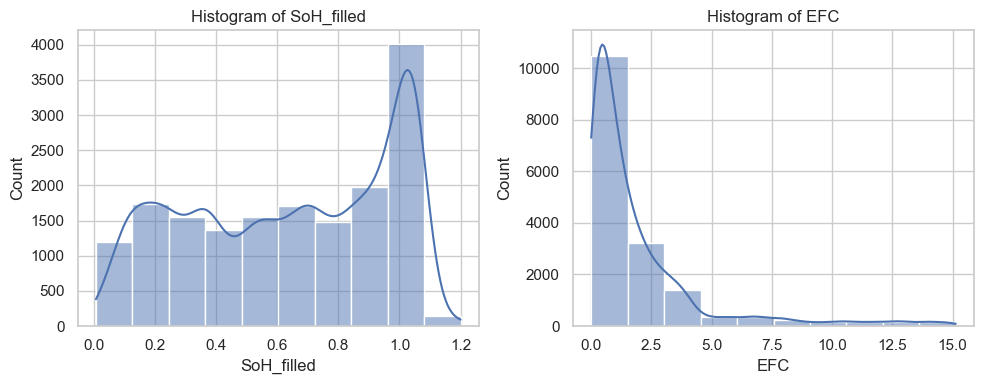

In [88]:
import seaborn as sns

plt.rcParams['agg.path.chunksize'] = 20000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# List of numerical columns
numerical_cols = ["SoH_filled", "EFC"]

# Plot histograms for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(df_filtered[col], bins=10, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

In [89]:
MAX_ROWS = 500

df_limited = (
    df_fe
    .sort_values(["device_id", "created_at"])    
    .groupby("device_id")
    .head(MAX_ROWS)   
    .reset_index(drop=True)
)

print("Before limiting :", df_fe.shape)
print("After limiting  :", df_limited.shape)

# gunakan df_limited untuk seluruh training selanjutnya
df_fe = df_limited

Before limiting : (17584, 275)
After limiting  : (8705, 275)


### Train Test Split

Split data into train, test, and split variation. Also exclude devices that has 100% State of Health

In [92]:
# Set random seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Split device IDs into train, validation, and test sets
device_ids = df_fe["device_id"].dropna().unique()

# Exclude Samsung S25 devices
s25_ids = [d for d in device_ids if str(d).startswith("SM-S931B")]
s23_plus_ids = [d for d in device_ids if str(d).startswith("SM-S916B")]
poco_ids = [d for d in device_ids if str(d).startswith("2311DRK48G")]
a33_ids = [d for d in device_ids if str(d).startswith("SM-A336E-c471046323c8859c")]
vivo_ids = [d for d in device_ids if str(d).startswith("V2050")] 
a25_ids = [d for d in device_ids if str(d).startswith("SM-A256E")]
oppo_ids = [d for d in device_ids if str(d).startswith("CPH2579")]

other_ids = np.array([d for d in device_ids if d not in s25_ids])

# Check devices
print("Total devices:", len(device_ids))
print("S25 (SM-S931B) devices:", s25_ids)
print("S23+ (SM-S916B) devices:", s23_plus_ids)
print("Poco (2311DRK48G) devices:", poco_ids)
print("A33 (SM-A336E) devices:", a33_ids)
print("Vivo (V2050) devices:", vivo_ids)
print("A25 (SM-A256E) devices:", a25_ids)
print("Other devices:", len(other_ids))

Total devices: 22
S25 (SM-S931B) devices: ['SM-S931B-57bc0e2d9eac7750']
S23+ (SM-S916B) devices: ['SM-S916B-205d95c2abec51c0']
Poco (2311DRK48G) devices: ['2311DRK48G-b135dcd1d7e9320f']
A33 (SM-A336E) devices: ['SM-A336E-c471046323c8859c']
Vivo (V2050) devices: ['V2050-b202c09b34bc8540']
A25 (SM-A256E) devices: ['SM-A256E-7e0aca17c219854b']
Other devices: 21


In [105]:
# Shuffle devices
rng.shuffle(other_ids)

# 70% train, 15% val, 15% test
n_train = int(0.7 * len(device_ids))
n_val   = int(0.15 * len(device_ids))

# Assign device IDs to each set
train_ids = device_ids[:n_train]
val_ids   = device_ids[n_train:n_train+n_val]
test_ids  = device_ids[n_train+n_val:]

# Add S25 to train set
train_ids = np.concatenate([train_ids, np.array(s25_ids, dtype=object)])
test_ids = np.concatenate([test_ids, np.array(a33_ids, dtype=object)])
test_ids = [d for d in test_ids if d not in s25_ids]
test_ids = [d for d in test_ids if d not in vivo_ids]
train_ids = [d for d in train_ids if d not in oppo_ids]


# Create DataFrames for each set
df_train = df_fe[df_fe["device_id"].isin(train_ids)].copy()
df_val   = df_fe[df_fe["device_id"].isin(val_ids)].copy()
df_test  = df_fe[df_fe["device_id"].isin(test_ids)].copy()

print("=== SPLIT DEVICES ===")
print("Train IDs:", train_ids)
print("Val IDs  :", val_ids)
print("Test IDs :", test_ids)

=== SPLIT DEVICES ===
Train IDs: ['2311DRK48G-b135dcd1d7e9320f', '23124RA7EO-3eb11a599d8b922d', '2406APNFAG-4b17a6ddf26cd705', '24117RN76O-af9a140a5e0ea0de', 'SM-A155F-7d69b63bc200801a', 'SM-A256E-7e0aca17c219854b', 'SM-A336E-c471046323c8859c', 'SM-A336E-c89e0bb491fe3651', 'SM-A356E-4e32dd36015962aa', 'SM-A546E-1cf82eec40a3542b', 'SM-A546E-701861f29b4d5913', 'SM-A546E-8af17d67f9288898', 'SM-A556E-5f0400c50aae82ca', 'SM-A556E-7ecd175336df7fc4', 'SM-S931B-57bc0e2d9eac7750']
Val IDs  : ['SM-A725F-6698366a2e3a4ff1' 'SM-S911B-aee10fcb8586030e'
 'SM-S916B-205d95c2abec51c0']
Test IDs : ['SM-S921B-d2c3f5675ad3a14d', 'SM-S926B-1ccc6862dc88e6b9', 'SM-A336E-c471046323c8859c']


### Subset and Scaler

Scale the data and create subset

In [106]:
from sklearn.preprocessing import StandardScaler

# Define preparation function
def prepare_subset(df, feature_cols, target_col):
  df = df.sort_values(["device_id", "created_at"]).copy()
  X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
  y = df[target_col].astype(float).values
  dev = df["device_id"].astype(str).values
  ts  = pd.to_datetime(df["created_at"]).values
  efc = df["EFC"].astype(float).values
  return X, y, dev, ts, efc

X_tr_raw, y_tr, dev_tr, t_tr, efc_tr = prepare_subset(df_train, feature_cols, target_col_soh)
X_va_raw, y_va, dev_va, t_va, efc_va = prepare_subset(df_val,   feature_cols, target_col_soh)
X_te_raw, y_te, dev_te, t_te, efc_te = prepare_subset(df_test,  feature_cols, target_col_soh)

scaler_X = StandardScaler().fit(X_tr_raw)
X_tr = scaler_X.transform(X_tr_raw)
X_va = scaler_X.transform(X_va_raw)
X_te = scaler_X.transform(X_te_raw)


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# 1. Siapkan daftar device & split
# ============================================

# Misal device_id diambil dari dataframe
devices = sorted(df_filtered["device_id"].unique())
assert len(device_ids) == 20, f"Expected 20 devices, got {len(device_ids)}"

# Contoh: 14 device pertama = train, 3 berikutnya = val, 3 terakhir = test
train_devs = train_ids
val_devs   = val_ids
test_devs  = test_ids

# Buat list label split untuk setiap device
split_label = []
for d in devices:
    if d in train_devs:
        split_label.append("Train")
    elif d in val_devs:
        split_label.append("Val")
    else:
        split_label.append("Test")

# Map warna
color_map = {"Train": "#90CAF9", "Val": "#FFF59D", "Test": "#FFAB91"}
colors = [color_map[s] for s in split_label]

# ============================================
# 2. Plot bar horizontal per device
# ============================================

plt.figure(figsize=(10, 6))

y_pos = np.arange(len(devices))

# Setiap device = 1 bar, panjang = 1 (hanya untuk visual)
plt.barh(y_pos, [1]*len(devices), color=colors, edgecolor="black")

plt.yticks(y_pos, devices)
plt.xticks([])  # x-axis tidak dipakai (hanya kategori)

plt.title("Device Train / Val / Test Split")
plt.xlabel("")  # kosong saja

# Buat legend
from matplotlib.patches import Patch
legend_patches = [
    Patch(color=color_map["Train"], label="Train (14 device)"),
    Patch(color=color_map["Val"],   label="Validation (3 device)"),
    Patch(color=color_map["Test"],  label="Test (3 device)"),
]
plt.legend(handles=legend_patches, loc="lower right")

plt.tight_layout()
plt.show()


AssertionError: Expected 20 devices, got 22

### Time Sequence

Create function to make a sequence using 24 lookback

In [107]:
def make_sequences(X, y, dev, ts, efc, lookback):
  X_seq, y_seq, dev_seq, t_seq, efc_seq = [], [], [], [], []
  # indeks mulai per device
  df_idx = pd.DataFrame({"device_id": dev, "idx": np.arange(len(dev))})
  for d, rows in df_idx.groupby("device_id"):
    idxs = rows["idx"].values
    if len(idxs) <= lookback:
      continue
    for i in range(lookback, len(idxs)):
      j = idxs[i]
      j0 = idxs[i-lookback:i]
      X_seq.append(X[j0, :])
      y_seq.append(y[j])
      dev_seq.append(d)
      t_seq.append(ts[j])
      efc_seq.append(efc[j])
  return (
    np.array(X_seq, dtype=np.float32),
    np.array(y_seq, dtype=np.float32),
    np.array(dev_seq),
    np.array(t_seq),
    np.array(efc_seq, dtype=np.float32),
  )

# Define lookback window
lookback = 24

# Prepare sequences
X_train, y_train, dev_tr_seq, t_tr_seq, efc_tr_seq = make_sequences(X_tr, y_tr, dev_tr, t_tr, efc_tr, lookback)
X_val,   y_val,   dev_va_seq, t_va_seq, efc_va_seq = make_sequences(X_va, y_va, dev_va, t_va, efc_va, lookback)
X_test,  y_test,  dev_te_seq, t_te_seq, efc_te_seq = make_sequences(X_te, y_te, dev_te, t_te, efc_te, lookback)

print("Train seq:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train seq: (5364, 24, 225) Val: (1428, 24, 225) Test: (1428, 24, 225)


### LSTM Architecture

Create LSTM model using 2 layers and ADAM optimization

In [108]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Define features
n_features = X_train.shape[-1]

# Define LSTM model for SoH prediction
inp = layers.Input(shape=(lookback, n_features))
x = layers.Masking(mask_value=0.0)(inp)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
out_soh = layers.Dense(1, activation="sigmoid", name="soh_out")(x)  # 0–1

# Compile model
model_soh = models.Model(inputs=inp, outputs=out_soh)
model_soh.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss="mse",
  metrics=["mae"]
)
model_soh.summary()

cb = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),]

history = model_soh.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=64,
  callbacks=cb,
  verbose=1,
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 225)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 24, 225)   │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 24, 225)   │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 24)        │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 24, 64)    │     74,240 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 64)    │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     12,416 │ dropout_4[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soh_out (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,745 (342.75 KB)

 Trainable params: 87,745 (342.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0337 - mae: 0.1291 - val_loss: 0.0274 - val_mae: 0.1161
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0064 - mae: 0.0573 - val_loss: 0.0233 - val_mae: 0.1051
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0054 - mae: 0.0500 - val_loss: 0.0228 - val_mae: 0.1047
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - mae: 0.0458 - val_loss: 0.0212 - val_mae: 0.1020
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0048 - mae: 0.0445 - val_loss: 0.0170 - val_mae: 0.0930
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047 - mae: 0.0431 - val_loss: 0.0189 - val_mae: 0.0976
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0045 - mae: 0.0416 - val_loss: 0.0173 - val_mae: 0.0946
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045 - mae: 0.0410 - val_loss: 0.0187 - val_mae: 0.0954
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

### Evaluation

Create evaluation from training using data test

In [110]:
y_pred = model_soh.predict(X_test).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred) if np.var(y_test) > 1e-6 else np.nan
print(f"SoH — RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
SoH — RMSE=0.1304, MAE=0.0888, R2=0.6675


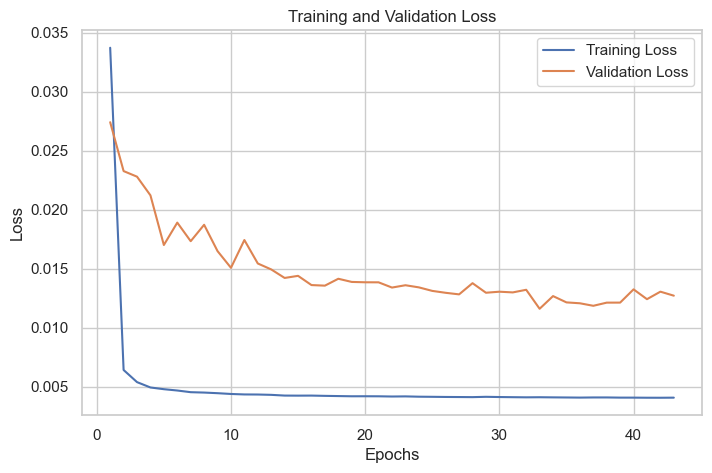

In [111]:
def plot_training_history(history):
  train_loss = history.history.get("loss")
  val_loss = history.history.get("val_loss")
  epochs = range(1, len(train_loss) + 1)
  
  # Plot training & validation loss values
  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_loss, label='Training Loss')
  if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss')
  
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.grid(True)
  plt.legend()
  plt.show()

plot_training_history(history)

## RUL Estimation

Create Remaining Useful Life estimation using Linear Regression with constant slope

In [112]:
from sklearn.linear_model import LinearRegression

def estimate_global_degradation_rate(df, soh_col="SoH_filled", efc_col="EFC"):
  slopes = []
  for dev, g in df.groupby("device_id"):
    g = g.dropna(subset=[soh_col, efc_col]).copy()
    if len(g) < 10:
      continue
    if g[efc_col].max() - g[efc_col].min() < 0.05:
      continue  
    X = g[[efc_col]].values
    y = g[soh_col].values
    reg = LinearRegression().fit(X, y)
    b = reg.coef_[0]
    if b < -1e-16:
      slopes.append(b)
  k = 0.2 / 500.0
  print("Warning: no valid slopes, using heuristic k =", k)
  return k

k_global = estimate_global_degradation_rate(df_train)
SoH_eol  = 0.7
print(f"SoH Drop per EFC: {k_global:.6f}, EOL SoH Threshold: {SoH_eol:.2f}")

SoH Drop per EFC: 0.000400, EOL SoH Threshold: 0.70


### Hours per Cycle Estimation

Create hours per cycles estimation

In [113]:
def estimate_hours_per_cycle(df, efc_col="EFC", time_col="created_at"):
  df = df.dropna(subset=[efc_col, time_col]).copy()
  df[time_col] = pd.to_datetime(df[time_col])
  df = df.sort_values(time_col)
    
  total_hours = (df[time_col].max() - df[time_col].min()).total_seconds() / 3600.0
  total_efc   = df[efc_col].max() - df[efc_col].min()
  if total_efc <= 0:
      return None
  return total_hours / total_efc

h_per_cycle = estimate_hours_per_cycle(df_train)
print("Approx hours per EFC:", h_per_cycle)

Approx hours per EFC: 174.18228719304486


### RUL Calculation

Calculate Remaining Useful Life from State of Health prediction

In [114]:
# Compute RUL from SoH
def compute_rul_from_soh(soh_pred, k, soh_eol=0.65, hours_per_cycle=None):
  soh_pred = np.asarray(soh_pred, dtype=float)
  soh_pred = np.clip(soh_pred, 0.0, 1.0)
  
  # RUL in EFC
  rul_cycles = (soh_pred - soh_eol) / k
  rul_cycles = np.maximum(rul_cycles, 0.0)
  if hours_per_cycle is not None:
    rul_hours = rul_cycles * hours_per_cycle
    return rul_cycles, rul_hours
  return rul_cycles, None

rul_cycles_pred, rul_hours_pred = compute_rul_from_soh(
  soh_pred=y_pred,
  k=k_global,
  soh_eol=SoH_eol,
  hours_per_cycle=h_per_cycle,
)

print("RUL_cycles_pred min/max:", rul_cycles_pred.min(), rul_cycles_pred.max())
if rul_hours_pred is not None:
  print("RUL_hours_pred min/max:", rul_hours_pred.min(), rul_hours_pred.max())


RUL_cycles_pred min/max: 0.0 749.9111890792848
RUL_hours_pred min/max: 0.0 130621.24610548574


In [115]:
from sklearn.metrics import root_mean_squared_error

rul_cycles_true, rul_hours_true = compute_rul_from_soh(
  soh_pred=y_test,
  k=k_global,
  soh_eol=SoH_eol,
  hours_per_cycle=h_per_cycle,
)

mae_rul_cycles  = mean_absolute_error(rul_cycles_true, rul_cycles_pred)
rmse_rul_cycles = root_mean_squared_error(rul_cycles_true, rul_cycles_pred)

print("MAE RUL (cycles):", mae_rul_cycles)
print("RMSE RUL (cycles):", rmse_rul_cycles)

if rul_hours_pred is not None:
  mae_rul_hours  = mean_absolute_error(rul_hours_true, rul_hours_pred)
  rmse_rul_hours = root_mean_squared_error(rul_hours_true, rul_hours_pred)
  print("MAE RUL (hours):", mae_rul_hours)
  print("RMSE RUL (hours):", rmse_rul_hours)

MAE RUL (cycles): 132.8271956545632
RMSE RUL (cycles): 235.27809644080412
MAE RUL (hours): 23136.144740549895
RMSE RUL (hours): 40981.27696448505


In [116]:
rul_true = np.asarray(rul_cycles_true, dtype=float).ravel()
rul_pred = np.asarray(rul_cycles_pred, dtype=float).ravel()
rul_abs_err = np.abs(rul_pred - rul_true)

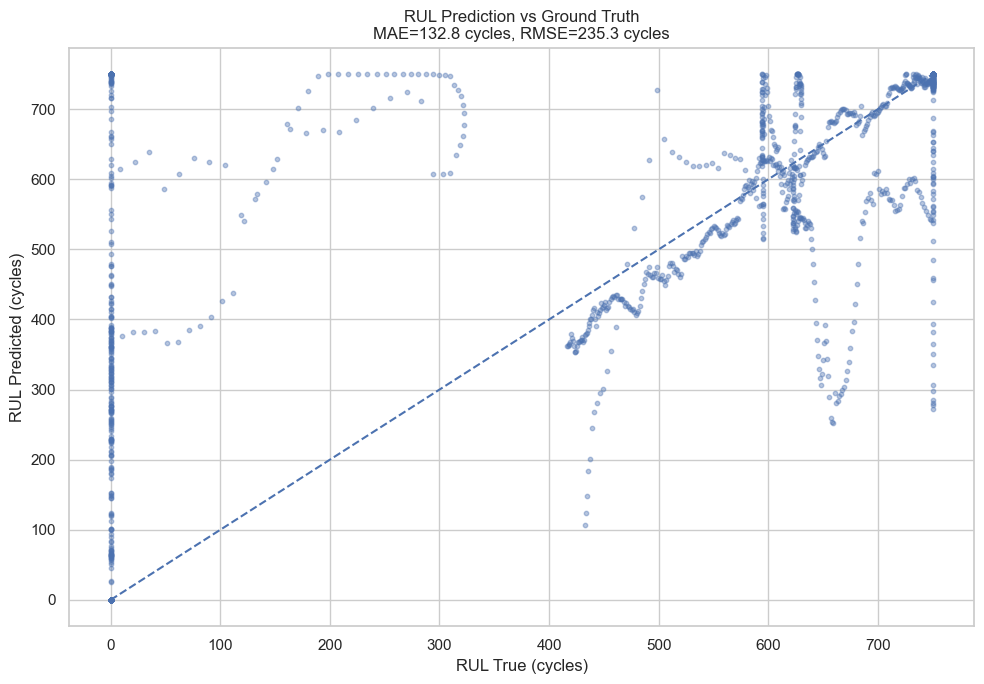

In [117]:
plt.figure(figsize=(10, 7))
plt.scatter(rul_true, rul_pred, alpha=0.4, s=10)
min_v = min(rul_true.min(), rul_pred.min())
max_v = max(rul_true.max(), rul_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.xlabel("RUL True (cycles)")
plt.ylabel("RUL Predicted (cycles)")
plt.title(f"RUL Prediction vs Ground Truth\nMAE={mae_rul_cycles:.1f} cycles, RMSE={rmse_rul_cycles:.1f} cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

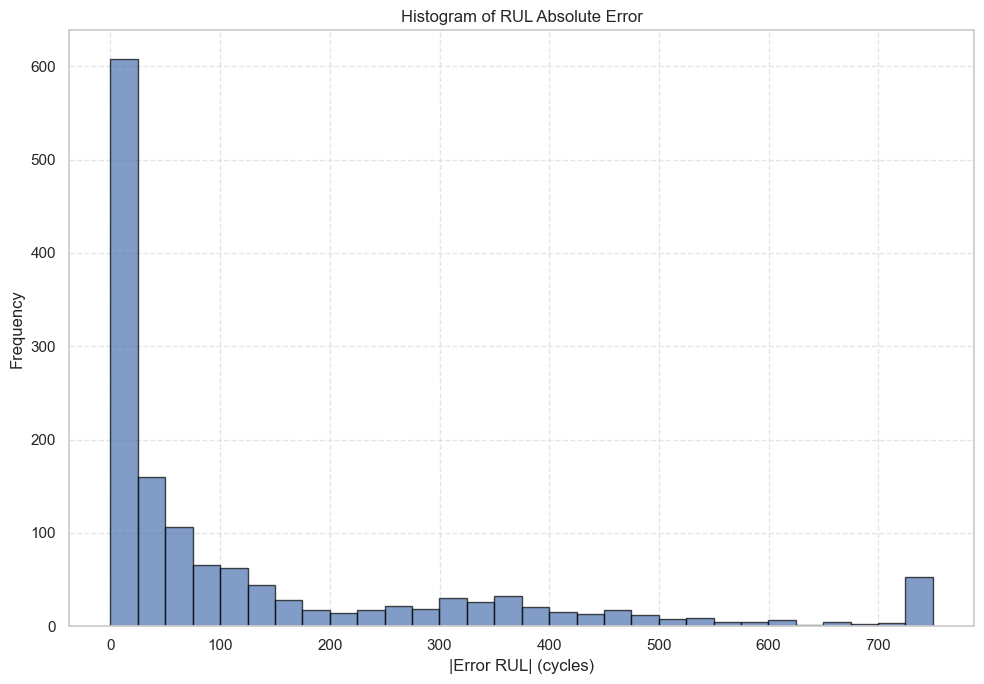

In [118]:
plt.figure(figsize=(10,7))
plt.hist(rul_abs_err, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("|Error RUL| (cycles)")
plt.ylabel("Frequency")
plt.title("Histogram of RUL Absolute Error")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Plot Metrics

Create line plot for every prediction metrics to extract insights for each devices

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

res = pd.DataFrame({
  "device_id": pd.Series(dev_te_seq, dtype=str),
  "created_at": pd.to_datetime(t_te_seq, errors="coerce"),
  "SoH_true":  y_test.astype(float).ravel(),
  "SoH_pred":  y_pred.astype(float).ravel(),
  "RUL_cycles": rul_cycles_pred.astype(float).ravel(),
  "RUL_hours":  rul_hours_pred.astype(float).ravel() if rul_hours_pred is not None else np.nan,
  "EFC": efc_te_seq.astype(float)
})

# Clear NaN/NaT
res = res.dropna(subset=["created_at"]).copy()
print(res.head())

                   device_id                 created_at  SoH_true  SoH_pred  \
0  SM-A336E-c471046323c8859c 2025-11-09 10:20:53.124852  1.035484  0.999951   
1  SM-A336E-c471046323c8859c 2025-11-09 10:35:59.923356  1.035484  0.999946   
2  SM-A336E-c471046323c8859c 2025-11-09 10:51:30.617534  1.035484  0.999947   
3  SM-A336E-c471046323c8859c 2025-11-09 11:07:31.085274  1.035484  0.999942   
4  SM-A336E-c471046323c8859c 2025-11-09 11:22:42.841948  1.035484  0.999954   

   RUL_cycles      RUL_hours       EFC  
0  749.877512  130615.380234  0.020454  
1  749.866188  130613.407640  0.022677  
2  749.867231  130613.589326  0.023353  
3  749.854863  130611.435046  0.024073  
4  749.884814  130616.652038  0.026739  


In [120]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def per_device_metrics(res_df):
    rows = []
    for dev, g in res_df.groupby("device_id"):
        y_true = g["SoH_true"].values
        y_pred = g["SoH_pred"].values
        if len(g) < 10:
            continue
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        try:
            r2   = r2_score(y_true, y_pred)
        except ValueError:
            r2 = np.nan
        rows.append((dev, len(g), mae, rmse, r2))
    return pd.DataFrame(rows, columns=["device_id","n","MAE","RMSE","R2"]).sort_values("R2")

df_dev_metrics = per_device_metrics(res)
print(df_dev_metrics)


                   device_id    n       MAE      RMSE        R2
2  SM-S926B-1ccc6862dc88e6b9  476  0.194304  0.213850 -0.602516
1  SM-S921B-d2c3f5675ad3a14d  476  0.059756  0.071037 -0.555066
0  SM-A336E-c471046323c8859c  476  0.012388  0.015636  0.906043


### Smoothing

Create smoothing for State of Health and monotonic RUL

In [121]:
# Sort values by device_id and EFC
res = res.sort_values(["device_id", "EFC"]).reset_index(drop=True)
res["SoH_pred_smooth"] = (
  res
    .groupby("device_id")["SoH_pred"]
    .transform(lambda s: (
      s.rolling(window=7, min_periods=1, center=True).mean()
  ))
)

# Smoothing function for RUL to be monotonic decreasing
def smooth_and_monotonic_rul(series, window=7):
  smoothed = series.rolling(window=window, min_periods=1, center=True).mean()
  arr = smoothed.to_numpy()
  mono = np.maximum.accumulate(arr[::-1])[::-1]
  return pd.Series(mono, index=series.index)

# Apply smoothing and monotonic constraint to RUL
res["RUL_cycles_smooth"] = (
  res
    .groupby("device_id")["RUL_cycles"]
    .transform(lambda s: smooth_and_monotonic_rul(s, window=7))
)

In [122]:
# Convert RUL from cycles to hours, days, months, years
rul_hours_pred = rul_cycles_pred * h_per_cycle
rul_days_pred = rul_hours_pred / 24.0
rul_months_pred = rul_days_pred / 30.0
rul_years_pred = rul_days_pred / 365.0

# Add to results DataFrame
res["RUL_hours_pred"] = rul_hours_pred
res["RUL_days_pred"] = rul_days_pred
res["RUL_months_pred"] = rul_months_pred
res["RUL_years_pred"] = rul_years_pred

### Plot SoH and RUL

Create function to plot SoH and RUL based on battery cycles

In [123]:
def plot_soh_rul_vs_cycle(df_plot, device_id, savepath=None):
    # Filter data untuk device tsb
    g = df_plot[df_plot["device_id"] == device_id].copy()
    g = g.dropna(subset=["EFC"])
    if g.empty:
        print(f"[WARN] Tidak ada data EFC untuk device {device_id} setelah merge.")
        return

    g = g.sort_values("EFC")
    g["SoH_true_pct"] = g["SoH_true"] * 100.0
    g["SoH_pred_smooth_pct"] = g["SoH_pred_smooth"] * 100.0

    # =========================
    # FIGURE 1: SoH vs EFC
    # =========================
    plt.figure(figsize=(10, 4))
    plt.plot(g["EFC"], g["SoH_true_pct"], label="SoH True (%)")
    plt.plot(g["EFC"], g["SoH_pred_smooth_pct"], label="SoH Pred (%)", alpha=0.8)
    plt.ylabel("SoH (%)")
    plt.xlabel("Equivalent Full Cycles (EFC)")
    plt.title(f"SoH terhadap Siklus — {device_id}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if savepath:
        soh_path = f"{savepath}_soh.png"
        plt.savefig(soh_path, dpi=200)
        print("Saved SoH figure:", soh_path)
        plt.close()
    else:
        plt.show()

    # =========================
    # FIGURE 2: RUL vs EFC
    # =========================
    plt.figure(figsize=(10, 4))
    plt.plot(g["EFC"], g["RUL_months_pred"], label="RUL (months)")
    plt.xlabel("Equivalent Full Cycles (EFC)")
    plt.ylabel("RUL (months)")
    plt.title(f"RUL terhadap Siklus — {device_id}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if savepath:
        rul_path = f"{savepath}_rul.png"
        plt.savefig(rul_path, dpi=200)
        print("Saved RUL figure:", rul_path)
        plt.close()
    else:
        plt.show()


test_devices = res["device_id"].unique()
print(test_devices)


['SM-A336E-c471046323c8859c' 'SM-S921B-d2c3f5675ad3a14d'
 'SM-S926B-1ccc6862dc88e6b9']


Create SoH and RUL plot for test devices

In [124]:
devices = [0, 1, 2]
os.makedirs("exports", exist_ok=True)
for i in devices:
  sample_dev = test_devices[i]
  plot_soh_rul_vs_cycle(res, sample_dev, savepath=f"exports/{sample_dev}_soh_rul_cycle.png")

Saved SoH figure: exports/SM-A336E-c471046323c8859c_soh_rul_cycle.png_soh.png
Saved RUL figure: exports/SM-A336E-c471046323c8859c_soh_rul_cycle.png_rul.png
Saved SoH figure: exports/SM-S921B-d2c3f5675ad3a14d_soh_rul_cycle.png_soh.png
Saved RUL figure: exports/SM-S921B-d2c3f5675ad3a14d_soh_rul_cycle.png_rul.png
Saved SoH figure: exports/SM-S926B-1ccc6862dc88e6b9_soh_rul_cycle.png_soh.png
Saved RUL figure: exports/SM-S926B-1ccc6862dc88e6b9_soh_rul_cycle.png_rul.png


## Feature Correlation

Create feature correlation for LSTM model

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== Correlation Feature vs SoH ===
                      corr_with_SoH_true  corr_with_SoH_pred
SoH_filled_z                    0.976178            0.888248
soh_trend_z                     0.562734            0.515892
soh_trend                       0.000954            0.169548
EFC_z                          -0.314336            0.087343
app_Chrome                      0.100392            0.076867
...                                  ...                 ...
app_Xbox                             NaN                 NaN
app_YouTube Music                    NaN                 NaN
app_YouTube ReVanced                 NaN                 NaN
app_myBCA                            NaN                 NaN
app_soundcore                        NaN                 NaN

[225 rows x 2 columns]


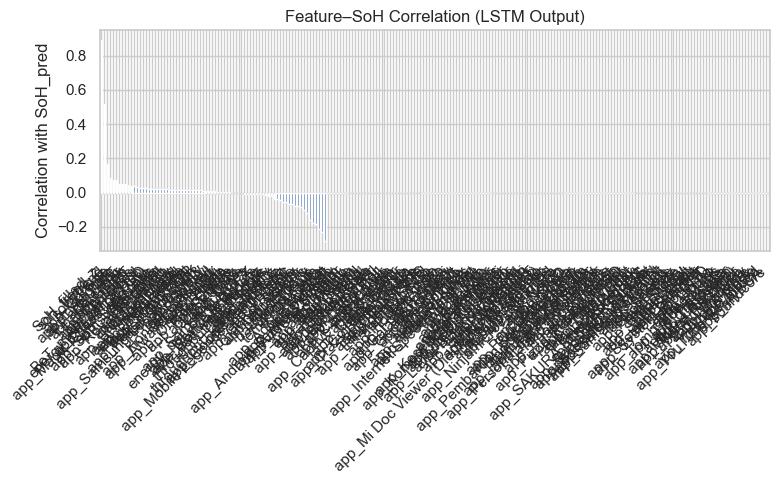

In [125]:
# SoH prediction correlation analysis
y_pred = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()

# Flatten sequence data
N, T, F = X_test.shape
X_flat = X_test.reshape(N*T, F)

# Repeat y_true and y_pred for each time step
y_true_rep = np.repeat(y_true, T)
y_pred_rep = np.repeat(y_pred, T)

# Create dataframe for correlation analysis
df_corr = pd.DataFrame(X_flat, columns=feature_cols)
df_corr["SoH_true"] = y_true_rep
df_corr["SoH_pred"] = y_pred_rep

# Calculate Pearson correlation
corr_true = df_corr.corr()["SoH_true"].drop(["SoH_true", "SoH_pred"])
corr_pred = df_corr.corr()["SoH_pred"].drop(["SoH_true", "SoH_pred"])
corr_df = pd.DataFrame({
  "corr_with_SoH_true": corr_true,
  "corr_with_SoH_pred": corr_pred
}).sort_values("corr_with_SoH_pred", ascending=False)

print("=== Correlation Feature vs SoH ===")
print(corr_df)

# Visualize correlation with SoH_pred
plt.figure(figsize=(8, 5))
corr_df["corr_with_SoH_pred"].plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title("Feature–SoH Correlation (LSTM Output)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Baseline RMSE: 0.13041255591645529
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

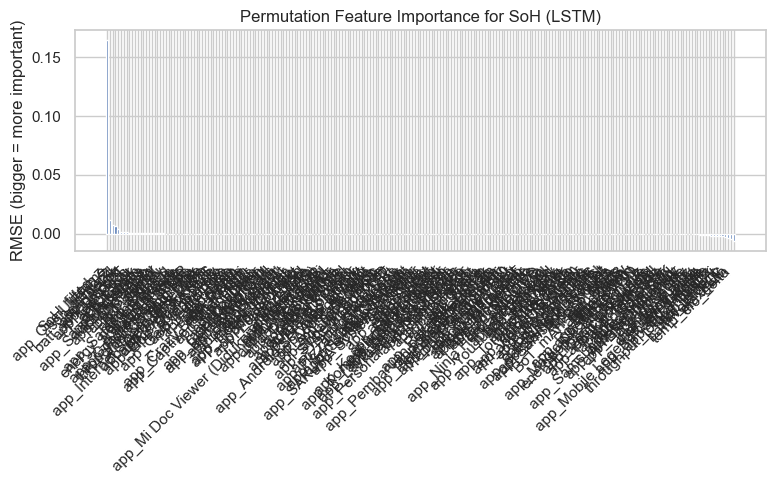

In [126]:
# Create RMSE function
def rmse(a, b):
  return np.sqrt(mean_squared_error(a, b))

# Baseline performance in test set
y_pred_base = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()
baseline_rmse = rmse(y_true, y_pred_base)
print("Baseline RMSE:", baseline_rmse)

# Permutation Feature Importance
N, T, F = X_test.shape
importances = []

# Loop through each feature for permutation
for feat_idx, feat_name in enumerate(feature_cols):
  X_perm = X_test.copy()
  idx_perm = np.random.permutation(N)
  X_perm[:, :, feat_idx] = X_test[idx_perm, :, feat_idx]
  
  # Feature prediction with permuted feature
  y_pred_perm = model_soh.predict(X_perm).squeeze()
  rmse_perm = rmse(y_true, y_pred_perm)
  delta_rmse = rmse_perm - baseline_rmse
  importances.append({
    "feature": feat_name,
    "rmse_perm": rmse_perm,
    "delta_rmse": delta_rmse
  })

# Result in dataframe
imp_df = pd.DataFrame(importances).sort_values("delta_rmse", ascending=False)
print("\n=== Permutation Feature Importance (SoH) ===")
print(imp_df)

# Plot bar importance
plt.figure(figsize=(8, 5))
plt.bar(imp_df["feature"], imp_df["delta_rmse"])
plt.ylabel("RMSE (bigger = more important)")
plt.title("Permutation Feature Importance for SoH (LSTM)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [127]:
import os
import json
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = f"models/{timestamp}"
os.makedirs(export_dir, exist_ok=True)

# Save model
model_soh.save(f"{export_dir}/model.keras")

# Save scaler
with open(f"{export_dir}/scaler.pkl", "wb") as f:
  pickle.dump(scaler_X, f)

# Print if saved
print("[OK] Saved scaler.pkl")
print("Model export directory:", export_dir)

[OK] Saved scaler.pkl
Model export directory: models/20251204_221917


In [128]:
# Create config dictionary
config = {
  "window_size": 24,
  "feature_cols": feature_cols,
  "target_col": "SoH_filled",
  "scaler_type": scaler_X.__class__.__name__,
  "model_version": timestamp,
  "rul_config": {
    "strategy": "global_linear_deterministic",
    "k_global": float(k_global),
    "soh_eol": float(SoH_eol),
    "hours_per_cycle": float(h_per_cycle) if h_per_cycle is not None else None,
    "notes": "k_global ~ average SoH drop per EFC; SoH in fraction [0,1]. "
    "RUL_cycles = max((SoH_pred - soh_eol) / k_global, 0)."
  },
}

# Save config as JSON
with open(f"{export_dir}/config.json", "w") as f:
  json.dump(config, f, indent=2)
print(f"[OK] Saved config.json at {export_dir}")

# Create metdata dictionary
metadata = {
  "created_at": timestamp,
  "num_devices": df["device_id"].nunique(),
  "num_rows": len(df),
}

# Save metadata as JSON
with open(f"{export_dir}/metadata.json", "w") as f:
  json.dump(metadata, f, indent=2)
print(f"[OK] Saved metadata.json at {export_dir}")

[OK] Saved config.json at models/20251204_221917
[OK] Saved metadata.json at models/20251204_221917


In [129]:
# Update latest model
import shutil

latest = "models/latest"
if os.path.exists(latest):
  shutil.rmtree(latest)

shutil.copytree(export_dir, latest)
print(f"[OK] Updated latest model at {latest}")

[OK] Updated latest model at models/latest


In [130]:
# Pisahkan kolom aplikasi & kolom numerik (core)
app_cols = [c for c in feature_cols if c.startswith("app_")]
core_cols = [c for c in feature_cols if c not in app_cols]

print("Jumlah fitur core :", len(core_cols))
print("Jumlah fitur app  :", len(app_cols))

Jumlah fitur core : 20
Jumlah fitur app  : 205


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== Correlation (core features vs SoH_pred) ===


,corr_with_SoH_pred
SoH_filled_z,0.888248
soh_trend_z,0.515892
soh_trend,0.169548
EFC_z,0.087343
BoT_mAh_per_Gbps,0.029202
energy_per_bit_avg_J,0.029202
epb_ema,0.022634
energy_per_bit_avg_J_z,-0.005784
batt_voltage_v_z,-0.011436
throughput_total_mbps,-0.021121



=== Correlation (app features vs SoH_pred) ===


,corr_with_SoH_pred
app_Chrome,0.076867
app_Instagram,0.071886
app_YouTube,0.052445
app_LINE,0.051053
app_Calendar,0.048598
...,...
app_Xbox,NaN
app_YouTube Music,NaN
app_YouTube ReVanced,NaN
app_myBCA,NaN


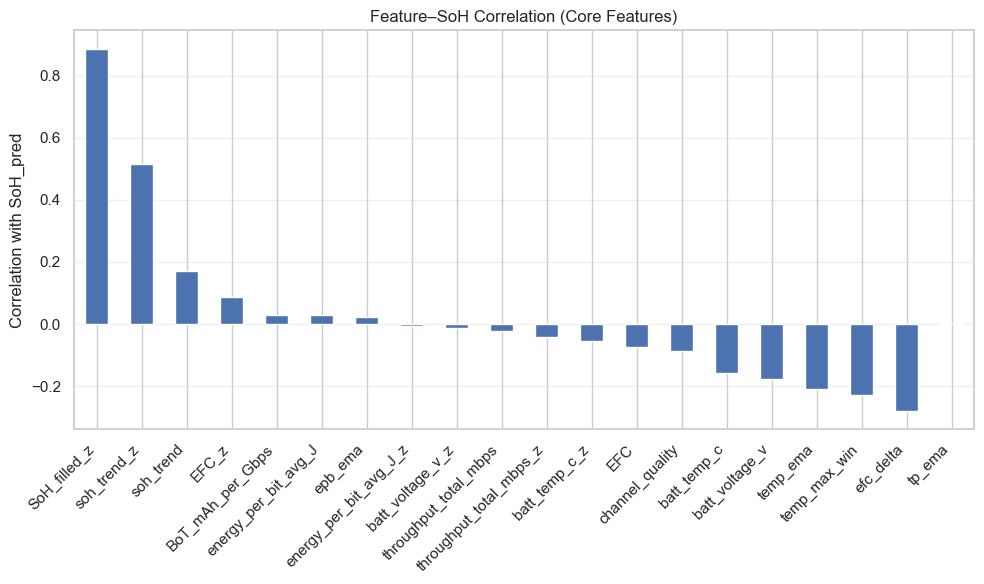

In [131]:
# ============================================
# SoH prediction correlation analysis (split core vs app)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prediksi SoH di test set
y_pred = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()

# 2. Flatten sequence: (N, T, F) -> (N*T, F)
N, T, F = X_test.shape
X_flat = X_test.reshape(N * T, F)

# 3. Repeat y_true & y_pred supaya align dengan tiap time-step
y_true_rep = np.repeat(y_true, T)
y_pred_rep = np.repeat(y_pred, T)

# 4. DataFrame untuk korelasi
df_corr = pd.DataFrame(X_flat, columns=feature_cols)
df_corr["SoH_true"] = y_true_rep
df_corr["SoH_pred"] = y_pred_rep

# 5. Hitung korelasi Pearson
corr_matrix = df_corr.corr()

# Kita fokus ke korelasi terhadap SoH_pred
corr_pred_all = corr_matrix["SoH_pred"].drop(["SoH_true", "SoH_pred"])

# 6. Split fitur: core (numeric) vs app (one-hot)
#    app_cols sudah didefinisikan sebelumnya waktu get_dummies
core_cols = [c for c in feature_cols if c not in app_cols]

corr_core = corr_pred_all[core_cols].sort_values(ascending=False)
corr_app  = corr_pred_all[app_cols].sort_values(ascending=False)

print("=== Correlation (core features vs SoH_pred) ===")
display(corr_core.to_frame(name="corr_with_SoH_pred"))

print("\n=== Correlation (app features vs SoH_pred) ===")
display(corr_app.to_frame(name="corr_with_SoH_pred"))

# 7. Plot: CORE FEATURES
plt.figure(figsize=(10, 6))
corr_core.plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title("Feature–SoH Correlation (Core Features)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



=== Correlation (app features vs SoH_pred) – non-zero only ===


,corr_with_SoH_pred
app_TikTok,-0.182692
app_Clock,-0.118247
app_WhatsApp,-0.098475
app_Clash Royale,-0.079727
app_Chrome,0.076867
app_Instagram,0.071886
app_Wibuku,-0.068258
app_Mobile Legends: Bang Bang,-0.063472
app_Google Play Store,-0.056265
app_YouTube,0.052445


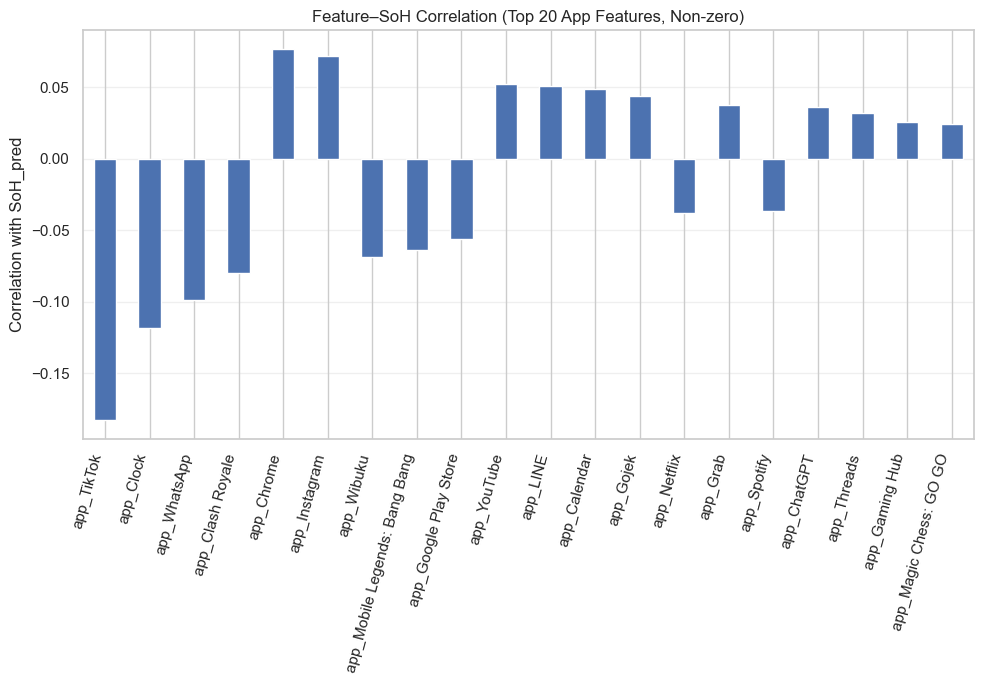

In [132]:
# 8. Plot: APP FEATURES (one-hot aplikasi)
# --- Korelasi app features (one-hot aplikasi) ---
# corr_app = corr_pred_all[app_cols].sort_values(ascending=False)  # ini baris lama

corr_app = corr_pred_all[app_cols].sort_values(ascending=False)

# Filter: hanya yang punya nilai dan tidak nol
corr_app_filtered = corr_app[~corr_app.isna() & (corr_app != 0.0)]

# Opsional: kalau masih kebanyakan, ambil TOP-N saja (misal 20 terbesar absolut)
TOP_N = 20
corr_app_top = corr_app_filtered.reindex(
    corr_app_filtered.abs().sort_values(ascending=False).head(TOP_N).index
)

print("\n=== Correlation (app features vs SoH_pred) – non-zero only ===")
display(corr_app_top.to_frame(name="corr_with_SoH_pred"))

plt.figure(figsize=(10, 7))
corr_app_top.plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title(f"Feature–SoH Correlation (Top {TOP_N} App Features, Non-zero)")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === RMSE helper ===
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

# === Baseline performance di test set ===
y_true = y_test.squeeze()
y_pred_base = model_soh.predict(X_test).squeeze()
baseline_rmse = rmse(y_true, y_pred_base)
print("Baseline RMSE:", baseline_rmse)

# === Split fitur: core vs app ===
app_cols = [c for c in feature_cols if c.startswith("app_")]
core_cols = [c for c in feature_cols if c not in app_cols]

print("Jumlah core features :", len(core_cols))
print("Jumlah app features  :", len(app_cols))

# === Permutation Feature Importance ===
N, T, F = X_test.shape
importances = []

# Flatten sekali di awal biar rapi
X_flat_orig = X_test.reshape(N * T, F)

for feat_idx, feat_name in enumerate(feature_cols):
    # Copy flatten
    X_flat_perm = X_flat_orig.copy()

    # Permutasi satu kolom fitur ini (acak di semua time-step & sequence)
    X_flat_perm[:, feat_idx] = np.random.permutation(X_flat_perm[:, feat_idx])

    # Kembalikan ke bentuk (N, T, F)
    X_perm = X_flat_perm.reshape(N, T, F)

    # Prediksi lagi dengan fitur yang di-permute
    y_pred_perm = model_soh.predict(X_perm).squeeze()
    rmse_perm = rmse(y_true, y_pred_perm)
    delta_rmse = rmse_perm - baseline_rmse

    importances.append({
        "feature": feat_name,
        "rmse_perm": rmse_perm,
        "delta_rmse": delta_rmse,
    })

# DataFrame semua fitur
imp_df = pd.DataFrame(importances).sort_values("delta_rmse", ascending=False)
print("\n=== Permutation Feature Importance (All Features) ===")
display(imp_df)

# ============================
# Pisah: CORE vs APP features
# ============================
imp_core = imp_df[imp_df["feature"].isin(core_cols)].copy()
imp_app  = imp_df[imp_df["feature"].isin(app_cols)].copy()

# Filter: hanya yang punya nilai dan delta_rmse != 0
imp_core = imp_core[imp_core["delta_rmse"].notna() & (imp_core["delta_rmse"] != 0.0)]
imp_app  = imp_app[imp_app["delta_rmse"].notna() & (imp_app["delta_rmse"] != 0.0)]

# Opsional: ambil TOP-N
TOP_N_CORE = 20
TOP_N_APP  = 20

imp_core_top = imp_core.sort_values("delta_rmse", ascending=False).head(TOP_N_CORE)
imp_app_top  = imp_app.sort_values("delta_rmse",  ascending=False).head(TOP_N_APP)

print(f"\n=== TOP {TOP_N_CORE} Core Features (by ΔRMSE) ===")
display(imp_core_top)

print(f"\n=== TOP {TOP_N_APP} App Features (by ΔRMSE) ===")
display(imp_app_top)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Baseline RMSE: 0.13041255591645529
Jumlah core features : 20
Jumlah app features  : 205
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━

,feature,rmse_perm,delta_rmse
15,SoH_filled_z,0.230488,0.100075
133,app_One UI Home,0.141510,0.011097
16,EFC_z,0.137204,0.006791
5,soh_trend,0.134415,0.004003
17,soh_trend_z,0.133821,0.003409
...,...,...,...
35,app_BiliBili,0.127970,-0.002442
0,batt_voltage_v,0.127234,-0.003178
8,temp_max_win,0.126517,-0.003895
6,efc_delta,0.123716,-0.006697



=== TOP 20 Core Features (by ΔRMSE) ===


,feature,rmse_perm,delta_rmse
15,SoH_filled_z,0.230488,0.100075
16,EFC_z,0.137204,0.006791
5,soh_trend,0.134415,0.004003
17,soh_trend_z,0.133821,0.003409
11,batt_voltage_v_z,0.131150,0.000738
12,batt_temp_c_z,0.130889,0.000476
18,BoT_mAh_per_Gbps,0.130433,0.000020
10,epb_ema,0.130423,0.000011
2,throughput_total_mbps,0.130418,0.000006
14,energy_per_bit_avg_J_z,0.130411,-0.000001



=== TOP 20 App Features (by ΔRMSE) ===


,feature,rmse_perm,delta_rmse
133,app_One UI Home,0.141510,0.011097
196,app_TikTok,0.132356,0.001943
62,app_Discord,0.131860,0.001448
221,app_blu,0.131537,0.001124
53,app_ChatGPT,0.131114,0.000701
63,app_Docs,0.131096,0.000684
86,app_Gojek,0.130964,0.000551
57,app_Clock,0.130871,0.000458
168,app_Samsung News,0.130717,0.000304
46,app_Camera,0.130683,0.000270


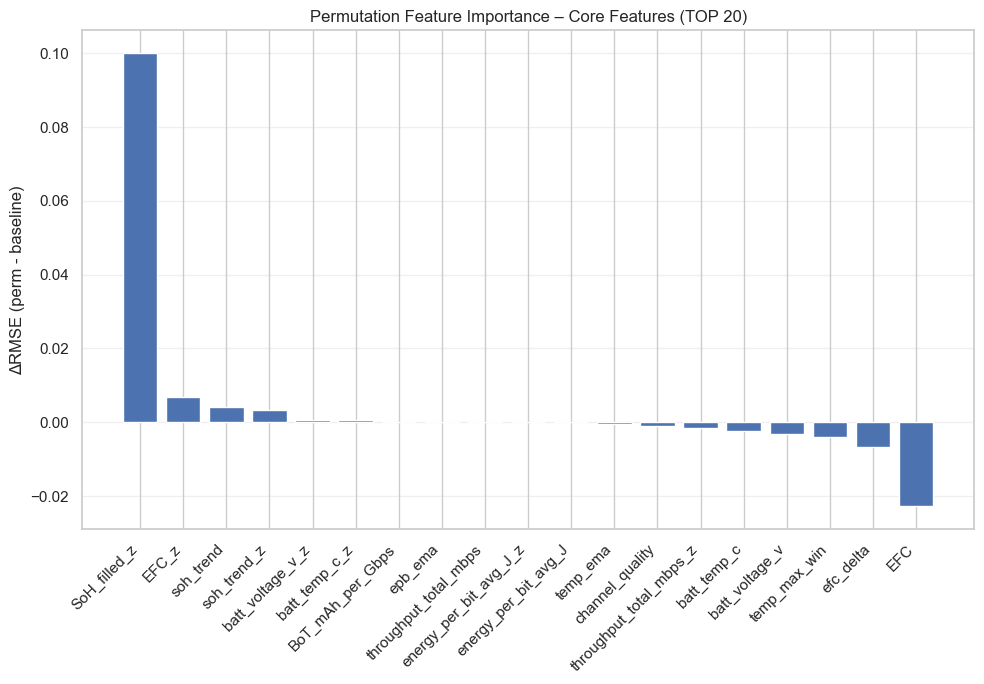

In [134]:
# =========
# PLOT CORE
# =========
plt.figure(figsize=(10, 7))
plt.bar(imp_core_top["feature"], imp_core_top["delta_rmse"])
plt.ylabel("ΔRMSE (perm - baseline)")
plt.title(f"Permutation Feature Importance – Core Features (TOP {TOP_N_CORE})")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

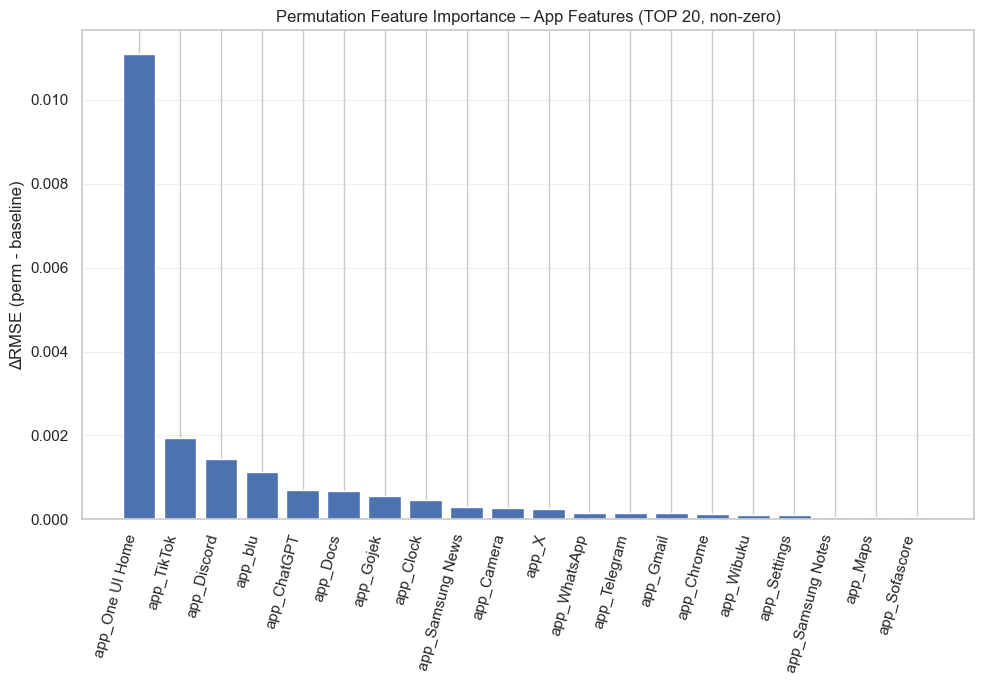

In [135]:
# ========
# PLOT APP
# ========
plt.figure(figsize=(10, 7))
plt.bar(imp_app_top["feature"], imp_app_top["delta_rmse"])
plt.ylabel("ΔRMSE (perm - baseline)")
plt.title(f"Permutation Feature Importance – App Features (TOP {TOP_N_APP}, non-zero)")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()